<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/PJH/CCIT_graphcodebert_c_N_N(%EA%B7%9C%EC%A0%9C_%EB%B0%8F_%EC%98%A4%EB%B2%84_%EC%83%98%ED%94%8C%EB%A7%81)_0606.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/sliceing_dataset.csv')

In [ ]:
df.head(10)

,Unnamed: 0,code_x,lang,CWE ID,vul,code_y
0,0,void CWE415_Double_Free__malloc_free_char_01_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
1,1,void CWE415_Double_Free__malloc_free_char_02_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
2,2,void CWE415_Double_Free__malloc_free_char_03_b...,c,CWE-415,1,data = NULL;\nif(5==5)\ndata = (char *)malloc(...
3,3,void CWE415_Double_Free__malloc_free_char_04_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
4,4,void CWE415_Double_Free__malloc_free_char_05_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
5,5,void CWE415_Double_Free__malloc_free_char_06_b...,c,CWE-415,1,data = NULL;\nif(STATIC_CONST_FIVE==5)\ndata =...
6,6,void CWE415_Double_Free__malloc_free_char_07_b...,c,CWE-415,1,data = NULL;\nif(staticFive==5)\ndata = (char ...
7,7,void CWE415_Double_Free__malloc_free_char_08_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
8,8,void CWE415_Double_Free__malloc_free_char_09_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
9,9,void CWE415_Double_Free__malloc_free_char_10_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...


In [ ]:
# code_x 컬럼 삭제
df = df.drop(columns=['code_x'])

# code_y 컬럼 이름을 code로 변경
df.rename(columns={'code_y': 'code'}, inplace=True)

# CWE ID에 따른 labels 컬럼 생성
cwe_mapping = {
    'CWE-415': 0,
    'CWE-119': 1,
    'CWE-20': 2,
    'CWE-125': 3,
    'CWE-787': 4,
    'CWE-416': 5,
    'CWE-476': 6,
    'CWE-399': 7,
    'CWE-190': 8
}

In [ ]:
df['labels'] = df['CWE ID'].map(cwe_mapping)

In [ ]:
df = df.drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['lang'])
df = df.drop(columns = ['vul'])
df = df.drop(columns = ['CWE ID'])

In [ ]:
df

,code,labels
0,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
1,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
2,data = NULL;\nif(5==5)\ndata = (char *)malloc(...,0
3,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
4,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
...,...,...
7289,const size_t so_ext_len= sizeof(SO_EXT) - 1;\n...,5
7290,"if (conn->out_size) {\nn=write(conn->hnd.fd, b...",4
7291,struct zlib_state *state = (struct zlib_state ...,7
7292,COMP_METHOD *meth = &zlib_method_nozlib;,7


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
# 오버샘플링 적용
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df.drop(columns=['labels']), df['labels'])

In [ ]:
# 오버샘플링된 데이터를 다시 Dataset 객체로 변환
df = pd.concat([X_res, y_res], axis=1)

In [ ]:
# 라벨이 int64 타입인지 확인
df['labels'] = df['labels'].astype(int)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [ ]:
import pandas as pd
import re
import gensim
import transformers
from gensim.models import Word2Vec
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from datasets import load_dataset
from pandas.core.common import random_state
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import logging
import sklearn.metrics as metric
from transformers import DataCollatorWithPadding
import torch,gc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from transformers import RobertaTokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, RobertaForSequenceClassification


In [ ]:
# 데이터 전처리 함수
def preprocess(df):
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "\n", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), " ", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    return df

df = preprocess(df)


In [ ]:
# 데이터셋 생성
dataset = Dataset.from_pandas(df)
def tokenized(examples):
    return tokenizer(examples['code'], padding="max_length", max_length=MAX_LEN, truncation=True)

In [ ]:
# 토크나이저 및 데이터셋 인코딩
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
MAX_LEN = 512
encoded_dataset = dataset.map(tokenized, batched=True)
encoded_dataset = encoded_dataset.train_test_split(0.3, seed=100)

# 모델 준비
model = AutoModelForSequenceClassification.from_pretrained("microsoft/graphcodebert-base", num_labels=9)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, betas=(0.9,0.99), eps=1e-8, weight_decay=0.1)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=5, num_training_steps=5)
optimizers = (optimizer, scheduler)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/14922 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_per_class = f1_score(labels, predictions, average=None, labels=range(9))
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }
    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1
    return metrics


In [ ]:
from transformers import TrainerCallback
class CustomTrainerCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, early_stopping_patience=5):
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.incorrect_samples = []

    def on_evaluate(self, args, state, control, **kwargs):
        eval_loss = kwargs.get('metrics', {}).get('eval_loss')
        if eval_loss is not None:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                print(f"No improvement in {self.early_stopping_patience} evaluation steps. Stopping training early.")
                control.should_training_stop = True
        eval_dataloader = self.trainer.get_eval_dataloader(self.eval_dataset)
        self.trainer.model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(self.trainer.args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.trainer.model(**batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = batch['labels']
                incorrect_mask = predictions != labels
            if incorrect_mask.any():
                incorrect_samples = {k: v[incorrect_mask].cpu().numpy() for k, v in batch.items()}
                self.incorrect_samples.append(incorrect_samples)
        print("Collected incorrect predictions for further analysis.")


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,  # 배치 크기를 줄임
    per_device_eval_batch_size=16,  # 배치 크기를 줄임
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='loss'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
callback = CustomTrainerCallback(trainer, encoded_dataset['test'], 5)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    callbacks=[callback]
)

gc.collect()
torch.cuda.empty_cache()


In [ ]:
# 디버깅 정보 출력
print("Training dataset size:", len(encoded_dataset['train']))
print("Validation dataset size:", len(encoded_dataset['test']))

trainer.train()


Training dataset size: 10445
Validation dataset size: 4477


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.827100,1.359326,0.534510,0.534510,0.521670,0.516947,0.534510,0.948640,0.234756,0.316436,0.481297,0.438584,0.620623,0.451813,0.616257,0.544118
1000,1.178300,0.984116,0.698682,0.698682,0.706584,0.703632,0.698682,0.957916,0.494715,0.609813,0.678663,0.644351,0.729670,0.673629,0.762938,0.780988
1500,0.738200,0.673092,0.806344,0.806344,0.810188,0.807727,0.806344,0.967679,0.644068,0.761803,0.746183,0.719080,0.859169,0.823799,0.889101,0.858661
2000,0.518800,0.528733,0.852133,0.852133,0.850796,0.848914,0.852133,0.967615,0.731230,0.820459,0.789474,0.787037,0.898810,0.859775,0.917796,0.868030
2500,0.463200,0.522305,0.867545,0.867545,0.870342,0.868673,0.867545,0.964844,0.718584,0.858650,0.850976,0.791489,0.881104,0.901532,0.928116,0.922764
3000,0.305300,0.494782,0.883851,0.883851,0.884064,0.882609,0.883851,0.972656,0.774049,0.870213,0.817424,0.848684,0.863799,0.923237,0.954111,0.919305
3500,0.256100,0.490860,0.896806,0.896806,0.897796,0.896327,0.896806,0.973555,0.778744,0.883966,0.856549,0.844490,0.937255,0.926778,0.952558,0.913043
4000,0.256300,0.493425,0.899486,0.899486,0.899981,0.898488,0.899486,0.974510,0.794578,0.875612,0.874351,0.877637,0.942000,0.879530,0.966052,0.902119
4500,0.170500,0.477425,0.905964,0.905964,0.905712,0.904495,0.905964,0.963250,0.806100,0.905782,0.886598,0.868559,0.944334,0.914807,0.967557,0.883469
5000,0.168400,0.487789,0.907304,0.907304,0.907996,0.906813,0.907304,0.974560,0.791625,0.907563,0.889610,0.883621,0.932302,0.934599,0.960990,0.886447


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predicti

TrainOutput(global_step=10500, training_loss=0.33094598043532597, metrics={'train_runtime': 8369.7838, 'train_samples_per_second': 12.479, 'train_steps_per_second': 1.56, 'total_flos': 2.2096402660417536e+16, 'train_loss': 0.33094598043532597, 'epoch': 8.039816232771823})

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


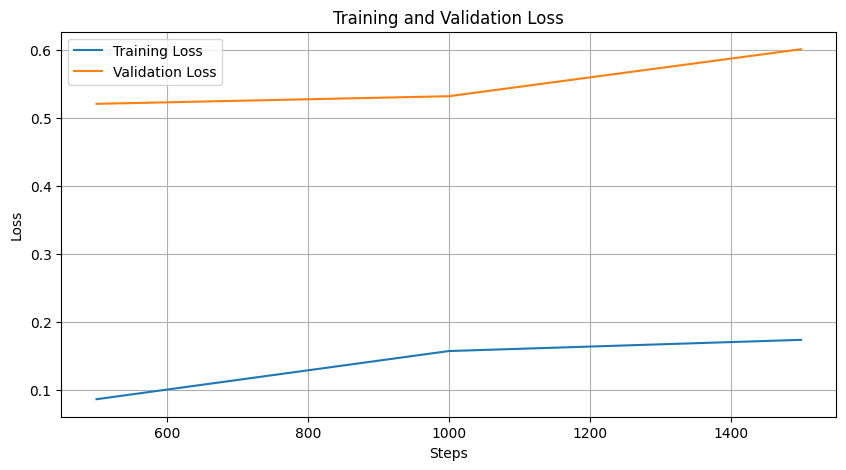

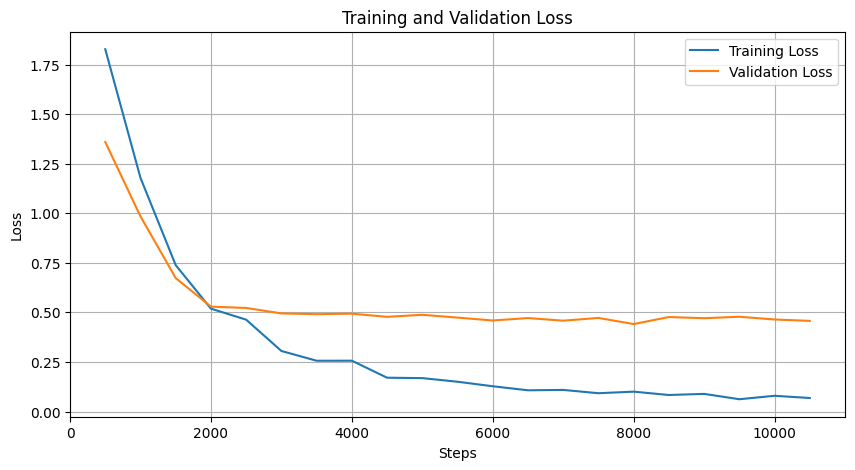

In [ ]:
# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')

test_dataset = encoded_dataset['test']


In [ ]:
# 평가 데이터셋에 대한 예측 수행
predictions = trainer.predict(test_dataset)


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,0.086200,0.520968,0.912888,0.912888,0.912909,0.911871,0.912888,0.976517,0.828541,0.910638,0.875752,0.890075,0.904265,0.942014,0.972035,0.906999
1000,0.157100,0.532200,0.912441,0.912441,0.912529,0.911548,0.912441,0.971485,0.804598,0.907388,0.911040,0.893082,0.937931,0.931507,0.943675,0.903226
1500,0.173600,0.601365,0.897253,0.897253,0.897064,0.896125,0.897253,0.976424,0.808777,0.894359,0.877419,0.861298,0.887876,0.937033,0.935160,0.886775


In [ ]:
# 예측된 레이블과 실제 레이블 추출
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids


In [ ]:
# 각 클래스별 F1 스코어 계산
class_f1_scores = f1_score(true_labels, predicted_labels, average=None)


In [ ]:
trainer.save_model('/content/drive/MyDrive/models/CCIT_graphcodebert_N:N(06-06)')

In [ ]:
import pandas as pd

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/data/MSR+julite_Dive_final_train/MSR+julite+Div_final_test.csv")

In [ ]:
df2.head(50)

In [ ]:
df2 = df2[['vul', 'code']]

In [ ]:
import re

def preprocess2(df2, file_name):
    # 멀티 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df2['code'] = df2['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df2['code'] = df2['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df2['code'] = df2['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df2['code'] = df2['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df2['code'] = df2['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    df2['code'] = df2['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df2.to_csv(file_name, index=False)
    return df2  # 수정된 데이터프레임 반환


In [ ]:
def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

preprocess2(df2,"preprocess2.csv")
dataset = load_dataset("csv",data_files="preprocess2.csv")['train']
encoded_dataset2 = dataset.map(tokenized,remove_columns=['code'],batched=True)
encoded_dataset2=encoded_dataset2.rename_column(original_column_name='vul',new_column_name='labels')


In [ ]:
trainer.predict(encoded_dataset2, metric_key_prefix="eval")